# Bar Path Tracker:

## Imports

In [111]:
import numpy as np
import os
import sys
import pandas
import cv2
import scipy

repo_path = r'C:\Users\ellio\OneDrive\Desktop\GitHub\bar_path_tracker'

## Basic Utils:

In [112]:
def open_and_display_video(path:str) -> None:
    
    vid = cv2.VideoCapture(os.path.join(repo_path, path))
    if (vid.isOpened()== False): 
        print("Error opening video stream or file")
    else:
        print(f"Playing video at {path}. Hit 'q' to quit.")
    
    while(vid.isOpened()):
        # Capture frame-by-frame
        ret, frame = vid.read()
        
        if ret == True:
            cv2.imshow('Frame',frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else: 
            break
    # When everything done, release the video capture object
    vid.release()
    # Closes all the frames
    cv2.destroyAllWindows()
    
open_and_display_video(r'data\example_videos\squat_example.mp4')

Playing video at data\example_videos\squat_example.mp4. Hit 'q' to quit.


In [113]:
tracker = cv2.TrackerCSRT_create()
tracker_type = "CSRT"

In [182]:
# Get the video file and read it

bar_path = []
times = []

cv2.destroyAllWindows()
video = cv2.VideoCapture(os.path.join(repo_path, r'data\example_videos\bench_example.mp4'))
ret, frame = video.read()
if not ret:
    print('cannot read the video')

frame_height, frame_width = frame.shape[:2]

frame_height = 2000
frame_width = 2000

# Resize the video for a more convinient view
frame = cv2.resize(frame, [frame_width//2, frame_height//2])

mask = np.zeros_like(frame)

# Initialize video writer to save the results
output = cv2.VideoWriter(f'{tracker_type}.mp4', 
                         cv2.VideoWriter_fourcc(*'XVID'), 60.0, 
                         (frame_width//2, frame_height//2), True)

# Select the bounding box in the first frame
bbox = cv2.selectROI(frame, False)
start_bbox = list(bbox)
previous_c = (int(bbox[0] + bbox[2]/2), int(bbox[1] + bbox[3]/2))

bar_path.append(previous_c)

ret = tracker.init(frame, bbox)
# Start tracking

while True:
    ret, frame = video.read()
    if not ret:
        break

    frame = cv2.resize(frame, [frame_width//2, frame_height//2])
    timer = cv2.getTickCount()
    ret, bbox = tracker.update(frame)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    if ret:
        p1 = (int(bbox[0]), int(bbox[1])) # top left
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])) # bottom right

        c = (int(bbox[0] + bbox[2]/2), int(bbox[1] + bbox[3]/2))
        bar_path.append([c[0], c[1]])
        times.append(timer)

        color = (255,255,255)

        """

        pad_scale_factor = 1.01

        padded_roi = [
            (int(bbox[0]*(2-pad_scale_factor)), int(bbox[1]*(2-pad_scale_factor))),
            (int(bbox[0]*pad_scale_factor + bbox[2]), int(bbox[1]*pad_scale_factor + bbox[3]*1.1))
        ]

        roi = frame[padded_roi[0][1]:padded_roi[1][1], padded_roi[0][0]:padded_roi[1][0], :]
        #roi = frame[p1[1]:p2[1], p1[0]:p2[0], :]


        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)


        gray = cv2.GaussianBlur(roi,(5,5),0);
        gray = cv2.medianBlur(gray,5)
        
        # Adaptive Guassian Threshold is to detect sharp edges in the Image. For more information Google it.
        gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,3.5)
        
        kernel = np.ones((3,3),np.uint8)
        gray = cv2.erode(gray,kernel,iterations = 1)
        # gray = erosion
        
        gray = cv2.dilate(gray,kernel,iterations = 1)

        detected_circles = cv2.HoughCircles(
            roi,
            cv2.HOUGH_GRADIENT,
            1,
            200,
            param1 = 30,
            param2 = 45,
            minRadius = 0,#int(min(bbox[2], bbox[3])*1.0/2),
            maxRadius = 0#int(max(bbox[2], bbox[3]) *1.1/2),
            )
        """
    
        mask = cv2.line(mask, previous_c, c, color, 2)
        frame = cv2.rectangle(frame, p1, p2, (255,255,255), 2, 1)
        #padded_frame = cv2.rectangle(frame, padded_roi[0], padded_roi[1], (0,255,255), 2, 1)

        """
        if detected_circles is not None:
            
            detected_circles = np.uint16(np.around(detected_circles))

            for pt in detected_circles[0, :]:
                a, b, r = padded_roi[0][0] + pt[0], padded_roi[0][1] + pt[1], pt[2]

                # Draw the circumference of the circle.
                padded_frame = cv2.circle(frame, (a, b), r, (0, 255, 0), 2)
        """
        

    else:
        cv2.putText(frame, "Tracking failure detected", (100,80), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75,(255,255,255),2)
    cv2.putText(frame, tracker_type + " Tracker", (0,20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
    cv2.putText(frame, "FPS : " + str(int(fps)), (0,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
    cv2.imshow("Tracking", cv2.add(frame, mask))
    output.write(cv2.add(frame, mask))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    previous_c = c
        
video.release()
output.release()
cv2.destroyAllWindows()

'\nd_xx = d_x[1:] - d_x[:-1]\nd_tt = d_t[1:] - d_t[:-1]\nspeed_t = speeds[1:] - speeds[:-1]\n\naccelerations = speed_t/d_t[1:]\n\naxs[3].plot(times[2:], accelerations, c = "r", linewidth  = 1)\naxs[3].set_ylabel("Force")\naxs[3].set_xlabel("Time")\naxs[3].set_xticks([])\naxs[3].set_yticks([])\n'

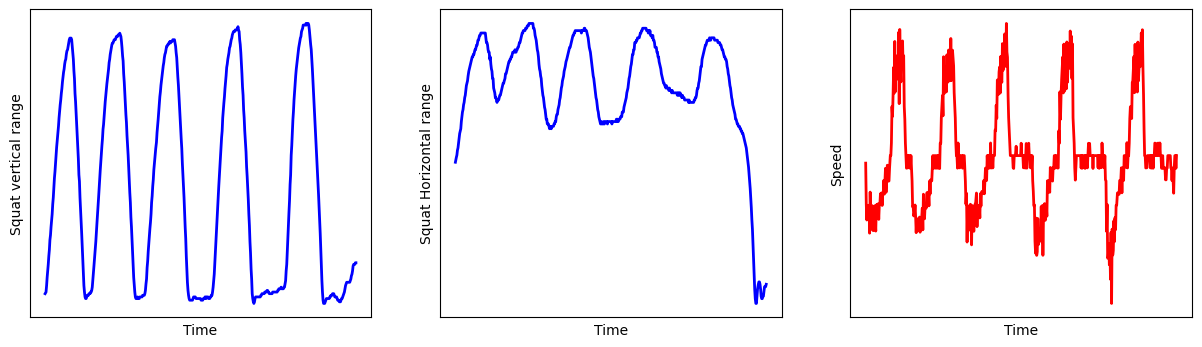

In [183]:
import matplotlib.pyplot as plt
bar_path = np.array(bar_path)

f, axs = plt.subplots(1,3, figsize = (15,4))

axs[0].plot(times, bar_path[1:,1], c = "b", linewidth  = 2)
axs[0].set_ylabel("Squat vertical range")
axs[0].set_xlabel("Time")
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].plot(times, bar_path[1:,0], c = "b", linewidth  = 2)
axs[1].set_ylabel("Squat Horizontal range")
axs[1].set_xlabel("Time")
axs[1].set_xticks([])
axs[1].set_yticks([])

times = np.array(times)

d_x = np.array(bar_path[2:,1]-bar_path[1:-1,1])
d_t = np.array(times[:-1] - times[1:])

speeds = d_x / d_t 

axs[2].plot(times[1:], speeds, c = "r", linewidth  = 2)
axs[2].set_ylabel("Speed")
axs[2].set_xlabel("Time")
axs[2].set_xticks([])
axs[2].set_yticks([])


"""
d_xx = d_x[1:] - d_x[:-1]
d_tt = d_t[1:] - d_t[:-1]
speed_t = speeds[1:] - speeds[:-1]

accelerations = speed_t/d_t[1:]

axs[3].plot(times[2:], accelerations, c = "r", linewidth  = 1)
axs[3].set_ylabel("Force")
axs[3].set_xlabel("Time")
axs[3].set_xticks([])
axs[3].set_yticks([])
"""

5


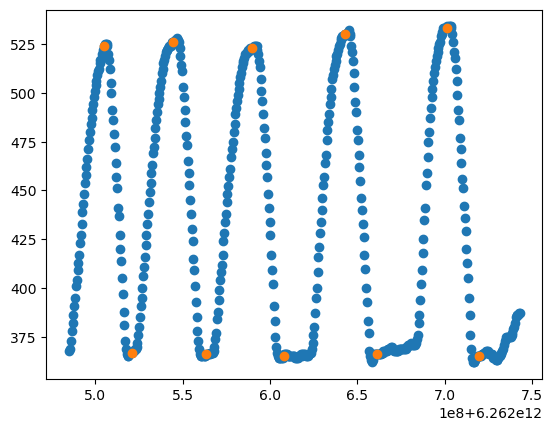

In [184]:
from scipy.signal import savgol_filter

v_displacements = bar_path[1:,1]
norm_v_displacements = (v_displacements - v_displacements.min())/(v_displacements.max() - v_displacements.min())
v_smoothed = savgol_filter(norm_v_displacements, 51, 5)

peaks = scipy.signal.find_peaks(v_smoothed, height=0.5)
troughs = scipy.signal.find_peaks(1 - v_smoothed, height=0.5)

num_peaks = len(peaks[0])
num_troughs = len(troughs[0])
num_reps = min(num_peaks, num_troughs)

tops = list(zip(peaks[0], peaks[1]['peak_heights']))
bottoms = list(zip(troughs[0], -1 * troughs[1]['peak_heights']))

heights = np.array([])
heights = np.append(heights, -1*troughs[1]['peak_heights'])
heights = np.append(heights, peaks[1]['peak_heights'])

tp_times = np.array([])
tp_times = np.append(tp_times, troughs[0])
tp_times = np.append(tp_times, peaks[0])

x = sorted(zip(tp_times, heights))


turning_points = {}

prev_sign = not x[0][1] < 0

for i, (t, h) in enumerate(x):

    sign = h < 0
    if sign != prev_sign or i ==0 :
        turning_points[int(t)] = h
        prev_h = h
    else:
        if sign:
            prev_h = min(h, prev_h)
        else:
            prev_h = max(h, prev_h)
    
    prev_sign = sign

extreme_times = list(turning_points.keys())
extreme_heights = list(turning_points.values())


plt.scatter(times, v_displacements)
plt.scatter(times[extreme_times], v_displacements[extreme_times])
print(num_reps)

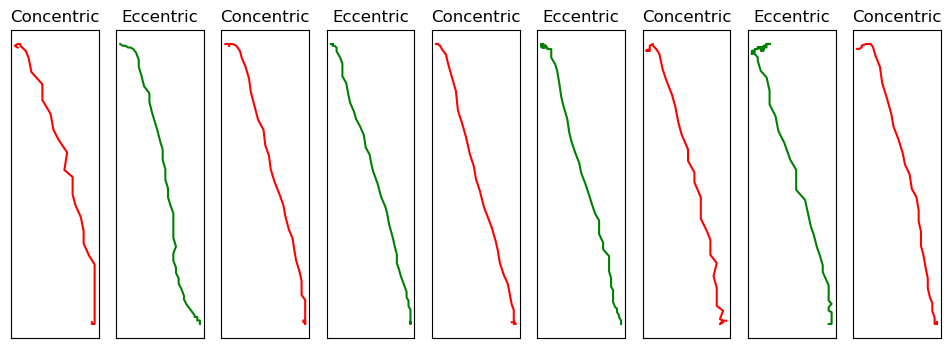

In [185]:
f, axs = plt.subplots(1, len(turning_points)-1, figsize = (12,4))


x_displacements = bar_path[1:,0]
y_displacements = bar_path[1:,1]

count = 0

for i in range(len(turning_points)-1):

    if extreme_heights[i] < 0:
        c = "green"
        title = "Eccentric"
    else:
        c = "red"
        title = "Concentric"

    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].plot(x_displacements[extreme_times[i]: extreme_times[i+1]],  -1 * y_displacements[extreme_times[i]: extreme_times[i+1]], c = c)
    axs[i].set_title(title)
    


In [190]:
# Get the video file and read it


cv2.destroyAllWindows()
video = cv2.VideoCapture(os.path.join(repo_path, r'data\example_videos\bench_example.mp4'))
ret, frame = video.read()
if not ret:
    print('cannot read the video')

frame_height, frame_width = frame.shape[:2]

frame_height = 2000
frame_width = 2000

# Resize the video for a more convinient view
frame = cv2.resize(frame, [frame_width//2, frame_height//2])

mask = np.zeros_like(frame)

# Initialize video writer to save the results
output = cv2.VideoWriter(f'{tracker_type}.mp4', 
                         cv2.VideoWriter_fourcc(*'XVID'), 60.0, 
                         (frame_width//2, frame_height//2), True)

ret = tracker.init(frame, bbox)
# Start tracking

norm_speeds = speeds/speeds.max()
counter = 0

while True:
    ret, frame = video.read()

    if not ret:
        break

    frame = cv2.resize(frame, [frame_width//2, frame_height//2])
    timer = cv2.getTickCount()
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if counter > 1:
        mask = cv2.line(mask, bar_path[counter-1], bar_path[counter], color, 2)

    cv2.putText(frame, " Bar Path Tracker", (0,20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
    cv2.putText(frame, "FPS : " + str(int(fps)), (0,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
    
    if counter < len(speeds):
        print(norm_speeds[counter])
        cv2.putText(frame, "Speed : " + str(round(norm_speeds[counter], 3)), (0,80), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
    else:
        cv2.putText(frame, "Speed : " + str(int(norm_speeds[-1])), (0,80), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255,255,255),2)
    
    counter +=1
    
    if counter > 1:
        cv2.imshow("Tracking", cv2.add(frame, mask))
    else:
        cv2.imshow("Tracking", cv2.add(frame, mask))
    output.write(cv2.add(frame, mask))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    previous_c = c
        
video.release()
output.release()
cv2.destroyAllWindows()

-0.05708423700702094
-0.3653674904064521
-0.48742282914571444
-0.38198044330406733
-0.3811474553739108
-0.4767257378441755
-0.37521645252594227
-0.5869771586174748
-0.2761267983660044
-0.4766544003485698
-0.3776437652614097
-0.3776607990046369
-0.5634595492398186
-0.38555276499611185
-0.5674333110887013
-0.5498977802022258
-0.379413718302775
-0.4880928611272227
-0.571223409701275
-0.37469512088807916
-0.36994294392514426
-0.375552246451089
-0.36453999925815334
-0.48278892570769927
-0.3766907077874223
-0.3681405431929387
-0.2883684805439604
-0.3670010056735166
-0.2820654218782661
-0.3773406595636258
-0.2880837393636733
-0.283641596129363
-0.18728330505554885
-0.29177492242494774
-0.1938766038585427
-0.09597570660392844
-0.2779689435697361
-0.1928110510874539
-0.0725477387055306
-0.18938442512433012
-0.1940396375659178
-0.19134646681196396
-0.09266608087558201
-0.0
-0.0
0.0958066877816668
0.37137283364630974
0.29651891540967307
0.46404844123954575
0.6677694451766051
0.4726668615205051
0.

In [ ]:
smoothed_speeds

In [ ]:
# savgol filter on speed, get forces

# write smooth func, write derrivative function

# convert nb to funtions